In [1]:
import sys 
import networkx as nx
import pandas as pd
import numpy as np
import pickle as pic
import random

import cassiopeia.TreeSolver.simulation_tools.simulation_utils as sim_utils
import cassiopeia.TreeSolver.simulation_tools.dataset_generation as data_gen
from cassiopeia.TreeSolver.Node import Node
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import subprocess

#import seaborn as sns
import os

In [2]:
def simulate_mutation(sample, mutation_prob_map):
    new_sample = []
    for i in range(0, len(sample)):
        character = sample[i]
        if character == '0':
            values, probabilities = zip(*mutation_prob_map[i].items())
            new_character = np.random.choice(values, p=probabilities)
            new_sample.append(new_character)
        else:
            new_sample.append(character)
    return new_sample

def simulate_dropout(sample, variable_dropout_probability_map):
    new_sample = []
    for i in range(0, len(sample)):
        if random.uniform(0, 1) <= variable_dropout_probability_map[i]:
            new_sample.append('-')
        else:
            new_sample.append(sample[i])
    return new_sample

def get_character_matrix(nodes):
    
    char_arrays = []
    for n in nodes:
        chars = n.char_string.split("_")[0].split("|")
        char_arrays.append(chars)
        
    return pd.DataFrame(char_arrays)

def compute_priors(C, S, p, mean=0.01, disp=0.1, skew_factor = 0.05, num_skew=1, empirical = np.array([]), mixture = 0):
    
    sp = {}
    prior_probabilities = {}
    for i in range(0, C):
        if len(empirical) > 0:
            sampled_probabilities = sorted(empirical)
        else:
            sampled_probabilities = sorted([np.random.negative_binomial(mean,disp) for _ in range(1,S+1)])
        s = C % num_skew
        mut_rate = p * (1 + num_skew * skew_factor)
        prior_probabilities[i] = {'0': (1-mut_rate)}
        total = np.sum(sampled_probabilities)

        sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
        
        if mixture > 0: 
            for s in range(len(sampled_probabilities)):
                if np.random.uniform() <= mixture:
                    sampled_probabilities[s] = np.random.uniform()
            
            sp[i] = sampled_probabilities 
            total = np.sum(sampled_probabilities)
            sampled_probabilities = list(map(lambda x: x / (1.0 * total), sampled_probabilities))
            
            
        for j in range(1, S+1):
            prior_probabilities[i][str(j)] = (mut_rate)*sampled_probabilities[j-1]

    return prior_probabilities, sp

def count_all_dropouts_leaves(leaves):
    count = 0
    for node in leaves:
        sample = node.get_character_string().split('|')
        for i in sample:
            if (i == '-' or i == '*'):
                count += 1
    return count

In [156]:
def hereditary_helper(network, node, dropout_probability_map, hereditary_drop_indices, counter):
    
    sample = node.get_character_string().split('|')
    temp_drop_indices = hereditary_drop_indices.copy()
    
    new_sample = []
    for i in range(0, len(sample)):
        if i in hereditary_drop_indices:
            new_sample.append('*')
        elif np.random.sample() <= dropout_probability_map[i]:
            new_sample.append('*')
            temp_drop_indices.append(i)
            counter[0] = counter[0] + 1
        else:
            new_sample.append(sample[i])
    
    node.char_vec = new_sample
    node.char_string = '|'.join([str(c) for c in new_sample])
    
    if network.out_degree(node) > 0:
        for i in network.successors(node):
            hereditary_helper(network, i, dropout_probability_map, temp_drop_indices, counter)

def stochastic_helper(network, node, dropout_probability_map, counter):
    sample = node.get_character_string().split('|')
    new_sample = simulate_dropout(sample, dropout_probability_map)
    
    node.char_vec = new_sample
    node.char_string = '|'.join([str(c) for c in new_sample])
    
    if network.out_degree(node) > 0:
        for i in network.successors(node):
            stochastic_helper(network, i, dropout_probability_map, counter)
            
def stochastic_helper_leaves(leaves, dropout_probability_map, counter):
    for node in leaves:
        sample = node.get_character_string().split('|')
        new_sample = simulate_dropout(sample, dropout_probability_map)
    
        node.char_vec = new_sample
        node.char_string = '|'.join([str(c) for c in new_sample])

In [ ]:
def generate_simulated_ground_tree(mutation_prob_map, characters=10, depth=10, min_division_rate=0.8, cell_death=0.01):
    network = nx.DiGraph()
    current_depth = [[['0' for _ in range(0, characters)], '0']]
    network.add_node(sim_utils.node_to_string(current_depth[0]))
    uniq = 1
    
    division_rate = min_division_rate+((1-min_division_rate)*np.random.random())
    
    for i in range(0, depth):
        temp_current_depth = []
        for node in current_depth:
            if np.random.random() >= cell_death:
                if np.random.random() <= division_rate:
                    for _ in range(0,2):
                        child_node = simulate_mutation(node[0], mutation_prob_map)
                        temp_current_depth.append([child_node, uniq])
                        network.add_edge(sim_utils.node_to_string(node), sim_utils.node_to_string([child_node, str(uniq)]))
                        uniq +=1
                else:
                    child_node = simulate_mutation(node[0], mutation_prob_map)
                    temp_current_depth.append([child_node, node[1]])
                    network = nx.relabel_nodes(network, {sim_utils.node_to_string(node): sim_utils.node_to_string([child_node, node[1]])}, copy = False)
            else:
                curr_parent = sim_utils.node_to_string(node)
                while network.out_degree(curr_parent) < 1 and network.in_degree(curr_parent) > 0:
                    next_parent = list(network.predecessors(curr_parent))[0]
                    network.remove_node(curr_parent)
                    curr_parent = next_parent
                
        current_depth = temp_current_depth

    rdict = {}
    i = 0
    for n in network.nodes:
        nn = Node("StateNode" + str(i), n.split("_")[0].split("|"), pid = n.split("_")[1], is_target=False)
        i += 1
        rdict[n] = nn

    network = nx.relabel_nodes(network, rdict)
    
#     source = [x for x in network.nodes() if network.in_degree(x)==0][0]

#     max_depth = max(nx.shortest_path_length(network,source,node) for node in network.nodes())
#     shortest_paths = nx.shortest_path_length(network,source)

#     leaves = [x for x in network.nodes() if network.out_degree(x)==0 and network.in_degree(x) == 1 and shortest_paths[x] == max_depth]

    leaves = [n for n in network if network.out_degree(n) == 0 and network.in_degree(n) == 1] 
    
    state_tree = Cassiopeia_Tree('simulated', network = network)
    return state_tree, leaves

In [157]:
#Set parameters. 'hdropout_percent' is a string that represents the dropout percent, for pathing purposes

no_mut_rate = .985
number_of_states = 40
dropout = 0.15
depth = 10
number_of_characters = 40

In [158]:
death_map = {"0": 0.00, "1": 0.01, "2": 0.02, "3": 0.03, "4": 0.04, "5": 0.05, "7": 0.07, "10": 0.10, "15": 0.15, "20": 0.20}

In [165]:
for death in death_map:

    death_rate = death_map[death]
    
    print(death)
    print(death_rate)

    #Create dropout maps
    dropouts = pd.DataFrame(np.full((number_of_characters, 1), dropout, dtype=float))
    dropout_prob_map = {i: dropout for i in range(0,number_of_characters)}

    #Establish the path, and create it if it doesn't yet exist
    path = "/data/yosef2/users/richardz/projects/dropout_testing/cell_death_testing_new_both/" + death + "percent"
    if os.path.exists(path) == False:
        os.mkdir(path)

    #Main loop for simulation
    cell_counts = []
    for i in range(0, 50):

        #Compute Priors and generate the simulated tree
        prior_probabilities = compute_priors(number_of_characters, number_of_states, 1-no_mut_rate, 5, 0.5, skew_factor=0.0, num_skew=1)[0]
        out, leaves = generate_simulated_ground_tree(prior_probabilities, characters=number_of_characters, depth=depth, min_division_rate= 0.8, cell_death = death_rate)
        #     pic.dump(out, open('/data/yosef2/users/richardz/projects/dropout_testing/ground_truth_testing/ground_truth_tree' + str(i) + '.pkl', 'wb'))
        while len(leaves) < 200:
            out, leaves = generate_simulated_ground_tree(prior_probabilities, characters=number_of_characters, depth=depth, min_division_rate= 0.8, cell_death = death_rate)

        network = out.get_network()
        #     pic.dump(out, open(path + '/sim_net' + str(i) + '.pkl', 'wb'))
        pic.dump(prior_probabilities, open(path + '/sim_net_priors' + str(i) + '.pkl', 'wb'))

        #Save the ground truth character matrix
        ground_cm = get_character_matrix(leaves)
        ground_cm.to_csv(path + '/ground_truth_cm' + str(i) + '.txt', sep = '\t')
        
        #Introduce Stochastic Dropout
        counter = [0]
        stochastic_helper_leaves(leaves, dropout_prob_map, counter)

        #Create the character matrix post dropout, giving names to the indeces
        dropout_cm = get_character_matrix(leaves)
        dropout_cm = dropout_cm.astype(str)
        row_names = ['c' + str(i) for i in range(dropout_cm.shape[0])]
        dropout_cm.index = row_names
        dropout_cm.to_csv(path + '/cell_death_cm' + str(i) + '.txt', sep = '\t')
        pic.dump(out, open(path + '/cell_death_net' + str(i) + '.pkl', 'wb'))
        
        #Count the dropout proportion and save it
        count = len(leaves)
        cell_counts.append(count)
        print(i, count)
        
    import csv

    #Write the dropout proportions to CSV
    with open('/data/yosef2/users/richardz/projects/dropout_testing/cell_death_testing_new/cell_death_percentage' + death + '.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerow(cell_counts)
    csvFile.close()


0
0.0
0 463
1 711
2 786
3 690
4 884
5 761
6 811
7 507
8 243
9 1023
10 953
11 672
12 419
13 1014
14 536
15 304
16 921
17 547
18 478
19 480
20 777
21 752
22 980
23 878
24 512
25 813
26 779
27 953
28 883
29 631
30 533
31 718
32 722
33 336
34 788
35 495
36 988
37 664
38 554
39 490
40 1015
41 786
42 549
43 838
44 808
45 686
46 861
47 964
48 724
49 467
1
0.01
0 814
1 801
2 265
3 952
4 654
5 515
6 345
7 887
8 566
9 969
10 951
11 417
12 343
13 450
14 428
15 417
16 938
17 531
18 241
19 669
20 925
21 847
22 883
23 473
24 893
25 619
26 555
27 326
28 494
29 280
30 479
31 928
32 350
33 239
34 1008
35 407
36 987
37 889
38 789
39 586
40 894
41 568
42 348
43 455
44 624
45 527
46 365
47 520
48 233
49 632
2
0.02
0 401
1 504
2 324
3 810
4 282
5 300
6 302
7 868
8 610
9 585
10 564
11 727
12 520
13 619
14 684
15 269
16 564
17 773
18 580
19 604
20 592
21 655
22 792
23 290
24 478
25 711
26 356
27 585
28 321
29 352
30 639
31 941
32 223
33 741
34 472
35 567
36 384
37 818
38 612
39 352
40 356
41 502
42 529
43 83

[['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], '0']
divided
[['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 1]
divided
[['0', '0', '0', '0', '6', '0', '0', '0', '0', '0'], 2]
divided
[['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 3]
divided
[['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 4]
divided
[['0', '0', '0', '0', '6', '0', '0', '0', '0', '0'], 5]
lived
[['0', '0', '0', '0', '6', '0', '0', '0', '0', '0'], 6]
lived
[[['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 7], [['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 8], [['6', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 9], [['0', '0', '0', '0', '0', '0', '0', '0', '0', '5'], 10], [['0', '0', '0', '0', '6', '0', '0', '0', '0', '0'], 5], [['10', '0', '0', '0', '6', '0', '0', '0', '0', '0'], 6]]
[<cassiopeia.TreeSolver.Node.Node object at 0x7fbea27b70f0>, <cassiopeia.TreeSolver.Node.Node object at 0x7fbea27b7d30>, <cassiopeia.TreeSolver.Node.Node object at 0x7fbea27b7048>, <cassiopeia.TreeSolver.Node.

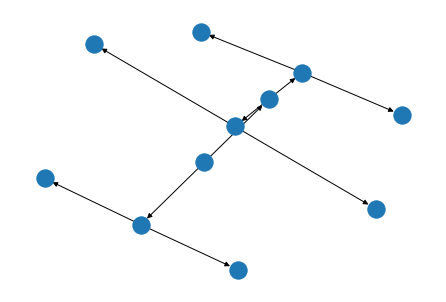

In [21]:
dropout = 0.15
no_mut_rate = .985
number_of_characters = 10
number_of_states = 10
dropouts = pd.DataFrame(np.full((number_of_characters, 1), dropout, dtype=float))
dropout_prob_map = {i: dropout for i in range(0,number_of_characters)}

prior_probabilities = compute_priors(number_of_characters, number_of_states, 1-no_mut_rate, 5, 0.5, skew_factor=0.0, num_skew=1)[0]
out, leaves = generate_simulated_ground_tree(prior_probabilities, characters=10, depth=3, min_division_rate = 0.0, cell_death = 0.2)
nx.draw(out.get_network())
print(leaves)